# Rangkuman Chapter 8: Dimensionality Reduction

## Berdasarkan buku "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow"

Notebook ini berisi rangkuman lengkap Chapter 8 dengan implementasi Python untuk Dimensionality Reduction, termasuk PCA, Kernel PCA, LLE, dan teknik lainnya.

## 1. Pengenalan Dimensionality Reduction

**Problem**: Many ML problems involve thousands atau millions of features untuk each training instance.

### Consequences:
- Training **extremely slow**
- Much harder to find good solution
- **Curse of dimensionality**

### Benefits of Dimensionality Reduction:
1. **Speed up training**: Fewer features → faster
2. **Data visualization**: Reduce to 2D/3D untuk plotting
3. **Filter noise**: May result in higher performance
4. **Save storage**: Compress data

### Important Notes:
⚠️ **Information loss**: Dimensionality reduction causes some information loss

⚠️ **Pipeline complexity**: Makes pipelines harder to maintain

⚠️ **Try original data first**: Before using dimensionality reduction

### Main Techniques:
1. **PCA** (Principal Component Analysis)
2. **Kernel PCA**
3. **LLE** (Locally Linear Embedding)
4. **t-SNE**, MDS, Isomap, dll

## 2. The Curse of Dimensionality

### 2.1 High-Dimensional Space Behavior

**Counterintuitive properties** dari high-dimensional space:

**Example 1: Closeness to borders**
- Unit square (2D): 0.4% chance point < 0.001 dari border
- 10,000-dimensional hypercube: >99.999999% chance!
- **Most points very close to border** dalam high dimensions

**Example 2: Average distances**
- Unit square: Average distance ≈ 0.52
- Unit 3D cube: Average distance ≈ 0.66
- 1,000,000-dimensional hypercube: Average distance ≈ 408.25!

### 2.2 Consequences

**Sparsity**: High-dimensional datasets at risk being very sparse
- Training instances far apart
- New instances far from training instances
- Predictions based on large extrapolations

**Result**: **Greater risk of overfitting**

### 2.3 Solution?

**Theory**: Increase training set size to reach sufficient density

**Practice**: Number of instances grows **exponentially** dengan number of dimensions

**Example**: Dengan 100 features, need more instances than **atoms in observable universe** untuk instances within 0.1 of each other!

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.datasets import make_swiss_roll

print("Libraries berhasil diimport!")

Libraries berhasil diimport!


## 3. Main Approaches untuk Dimensionality Reduction

### 3.1 Projection

**Key insight**: Training instances tidak spread uniformly across all dimensions.

**Result**: All training instances lie within (atau close to) much **lower-dimensional subspace**.

**Method**: Project instances perpendicularly onto lower-dimensional subspace.

In [2]:
# Generate 3D data lying close to 2D plane
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X_3d = np.empty((m, 3))
X_3d[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X_3d[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X_3d[:, 2] = X_3d[:, 0] * w1 + X_3d[:, 1] * w2 + noise * np.random.randn(m)

print(f"3D dataset: {X_3d.shape}")
print("Data lies close to 2D plane dalam 3D space")

3D dataset: (60, 3)
Data lies close to 2D plane dalam 3D space


### 3.2 Manifold Learning

**Limitation of simple projection**: Subspace may **twist and turn**.

**Example**: Swiss roll dataset
- Simply projecting → squashes different layers together
- Want to **unroll** the Swiss roll instead

**Manifold**: d-dimensional shape yang dapat bent dan twisted dalam higher-dimensional space.

**Manifold assumption (manifold hypothesis)**:
- Most real-world high-dimensional datasets lie close to much lower-dimensional manifold
- Very often empirically observed
- Task akan simpler jika expressed dalam lower-dimensional manifold space

In [3]:
# Generate Swiss roll dataset
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

print(f"Swiss roll dataset: {X_swiss.shape}")
print("3D dataset yang sebenarnya 2D manifold (rolled)")

Swiss roll dataset: (1000, 3)
3D dataset yang sebenarnya 2D manifold (rolled)


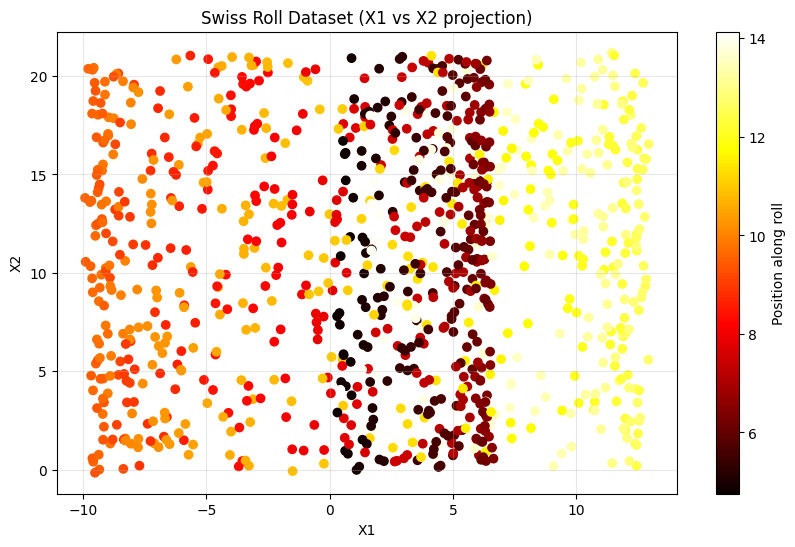

Simple projection squashes different layers together!


In [4]:
# Visualisasi Swiss roll (2D projection)
plt.figure(figsize=(10, 6))
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Swiss Roll Dataset (X1 vs X2 projection)")
plt.colorbar(label="Position along roll")
plt.grid(True, alpha=0.3)
plt.show()

print("Simple projection squashes different layers together!")

## 4. PCA (Principal Component Analysis)

**PCA** adalah by far **most popular** dimensionality reduction algorithm.

### 4.1 How PCA Works

1. **Identify hyperplane** closest to data
2. **Project data** onto hyperplane

### 4.2 Preserving Variance

**Key principle**: Select axis yang preserves **maximum variance**.

**Justification**:
- Most likely loses less information
- Minimizes mean squared distance between original dan projection

### 4.3 Principal Components

**Process**:
1. Find 1st axis: Accounts untuk largest variance
2. Find 2nd axis: Orthogonal to 1st, accounts untuk largest remaining variance
3. Continue untuk all dimensions

**ith principal component (PC)**: ith axis

### 4.4 Finding Principal Components

**Method**: **Singular Value Decomposition (SVD)**

Decompose training set matrix X into: \\( X = U \Sigma V^T \\)

**V** contains unit vectors defining all principal components:

\\[ V = \begin{bmatrix} c_1 & c_2 & \cdots & c_n \end{bmatrix} \\]

In [5]:
# Manual PCA implementation menggunakan SVD
X_centered = X_3d - X_3d.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]  # First principal component
c2 = Vt.T[:, 1]  # Second principal component

print("=== Manual PCA dengan SVD ===")
print(f"First PC: {c1}")
print(f"Second PC: {c2}")
print("\nNote: PCA assumes data centered around origin")

=== Manual PCA dengan SVD ===
First PC: [0.93636116 0.29854881 0.18465208]
Second PC: [-0.34027485  0.90119108  0.2684542 ]

Note: PCA assumes data centered around origin


In [6]:
# Project down to 2D
W2 = Vt.T[:, :2]  # First 2 principal components
X2D = X_centered.dot(W2)

print(f"\nOriginal shape: {X_3d.shape}")
print(f"Projected shape: {X2D.shape}")
print("\nSuccessfully reduced dari 3D ke 2D!")


Original shape: (60, 3)
Projected shape: (60, 2)

Successfully reduced dari 3D ke 2D!


### 4.5 Using Scikit-Learn

Scikit-Learn's **PCA class** uses SVD decomposition, sama seperti manual implementation.

In [7]:
# PCA dengan Scikit-Learn
pca = PCA(n_components=2)
X2D_sklearn = pca.fit_transform(X_3d)

print("=== Scikit-Learn PCA ===")
print(f"Components shape: {pca.components_.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"\nTotal variance preserved: {sum(pca.explained_variance_ratio_)*100:.1f}%")

=== Scikit-Learn PCA ===
Components shape: (2, 3)
Explained variance ratio: [0.84248607 0.14631839]

Total variance preserved: 98.9%


### 4.6 Explained Variance Ratio

**explained_variance_ratio_**: Indicates proportion of dataset's variance along each PC.

**Example**: 
- PC1: 84.2% of variance
- PC2: 14.6% of variance
- PC3: <1.2% of variance

→ PC3 probably carries little information

### 4.7 Choosing Right Number of Dimensions

**Method 1**: Choose number yang adds up to sufficiently large portion (e.g., 95%)

In [8]:
# Example: Find dimensions untuk 95% variance
# (Using Swiss roll untuk demonstration)
pca_full = PCA()
pca_full.fit(X_swiss)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(f"=== Choosing Number of Dimensions ===")
print(f"Original dimensions: {X_swiss.shape[1]}")
print(f"Dimensions untuk 95% variance: {d}")

=== Choosing Number of Dimensions ===
Original dimensions: 3
Dimensions untuk 95% variance: 3


In [9]:
# Method 2: Directly specify variance ratio
pca_95 = PCA(n_components=0.95)
X_reduced = pca_95.fit_transform(X_swiss)

print(f"\n=== Direct Variance Specification ===")
print(f"Requested: 95% variance")
print(f"Resulting dimensions: {X_reduced.shape[1]}")
print(f"Actual variance preserved: {sum(pca_95.explained_variance_ratio_)*100:.2f}%")


=== Direct Variance Specification ===
Requested: 95% variance
Resulting dimensions: 3
Actual variance preserved: 100.00%


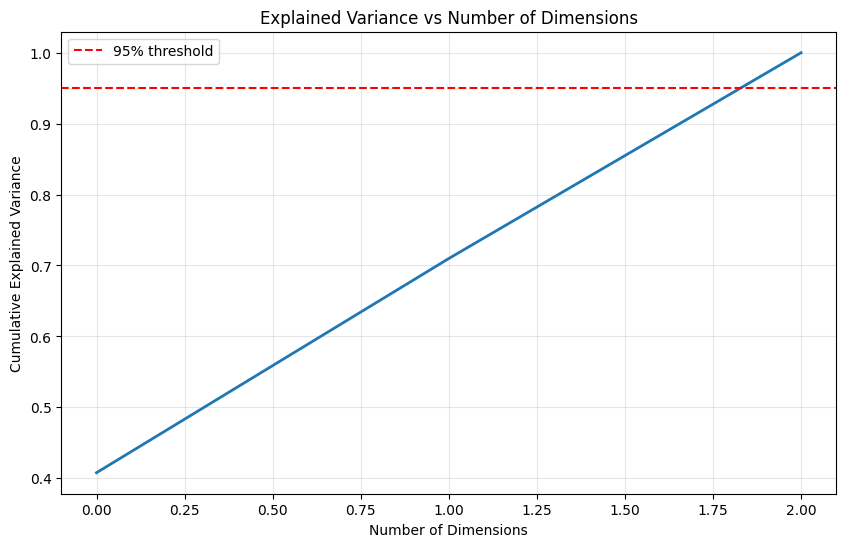

Look untuk elbow dalam curve!


In [10]:
# Method 3: Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumsum, linewidth=2)
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Dimensions")
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Look untuk elbow dalam curve!")

### 4.8 PCA for Compression

**Benefits**:
- Training set takes much less space
- Speeds up algorithms

**Example**: MNIST dengan 95% variance
- Original: 784 features
- Reduced: ~150 features
- Size: <20% of original

**Decompression**: Possible menggunakan `inverse_transform()`
- Won't give back exact original data
- Some information loss (within dropped variance)
- **Reconstruction error**: MSE between original dan reconstructed

In [11]:
# PCA compression dan decompression
pca_compress = PCA(n_components=2)
X_reduced = pca_compress.fit_transform(X_3d)
X_recovered = pca_compress.inverse_transform(X_reduced)

print("=== PCA Compression ===")
print(f"Original shape: {X_3d.shape}")
print(f"Compressed shape: {X_reduced.shape}")
print(f"Recovered shape: {X_recovered.shape}")

# Reconstruction error
from sklearn.metrics import mean_squared_error
reconstruction_error = mean_squared_error(X_3d, X_recovered)
print(f"\nReconstruction error (MSE): {reconstruction_error:.6f}")

=== PCA Compression ===
Original shape: (60, 3)
Compressed shape: (60, 2)
Recovered shape: (60, 3)

Reconstruction error (MSE): 0.003390


### 4.9 Randomized PCA

**Stochastic algorithm** untuk quickly find approximation dari first d PCs.

**Computational complexity**: O(m × d²) + O(d³)
- vs Full SVD: O(m × n²) + O(n³)
- **Dramatically faster** ketika d << n

**Usage**: Set `svd_solver="randomized"`

**Default**: `svd_solver="auto"`
- Automatically uses randomized PCA jika m atau n > 500 dan d < 80% of m atau n

In [12]:
# Randomized PCA
rnd_pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
X_reduced_rnd = rnd_pca.fit_transform(X_swiss)

print("=== Randomized PCA ===")
print(f"Reduced shape: {X_reduced_rnd.shape}")
print("Much faster untuk large datasets!")

=== Randomized PCA ===
Reduced shape: (1000, 2)
Much faster untuk large datasets!


### 4.10 Incremental PCA

**Problem**: Previous implementations require whole training set fit in memory.

**Solution**: **Incremental PCA (IPCA)**
- Split training set into mini-batches
- Feed one mini-batch at a time
- Useful untuk large training sets
- Useful untuk online learning

**Method**: Use `partial_fit()` with each mini-batch

In [13]:
# Incremental PCA
n_batches = 10
inc_pca = IncrementalPCA(n_components=2)

for X_batch in np.array_split(X_swiss, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced_inc = inc_pca.transform(X_swiss)

print("=== Incremental PCA ===")
print(f"Number of batches: {n_batches}")
print(f"Reduced shape: {X_reduced_inc.shape}")
print("Can handle datasets yang tidak fit in memory!")

=== Incremental PCA ===
Number of batches: 10
Reduced shape: (1000, 2)
Can handle datasets yang tidak fit in memory!


## 5. Kernel PCA

**Kernel trick** (dari Chapter 5) dapat applied to PCA!

### 5.1 Concept

**Kernel PCA (kPCA)**: Enables **complex nonlinear projections** untuk dimensionality reduction.

**Benefits**:
- Good at preserving clusters after projection
- Can unroll datasets close to twisted manifold

### 5.2 Common Kernels

- **Linear kernel**: Equivalent to PCA
- **RBF (Gaussian) kernel**: For smooth manifolds
- **Sigmoid kernel**: For certain patterns
- **Polynomial kernel**: For polynomial relationships

In [14]:
# Kernel PCA dengan RBF kernel
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced_kpca = rbf_pca.fit_transform(X_swiss)

print("=== Kernel PCA (RBF) ===")
print(f"Original shape: {X_swiss.shape}")
print(f"Reduced shape: {X_reduced_kpca.shape}")
print("Can unroll Swiss roll!")

=== Kernel PCA (RBF) ===
Original shape: (1000, 3)
Reduced shape: (1000, 2)
Can unroll Swiss roll!


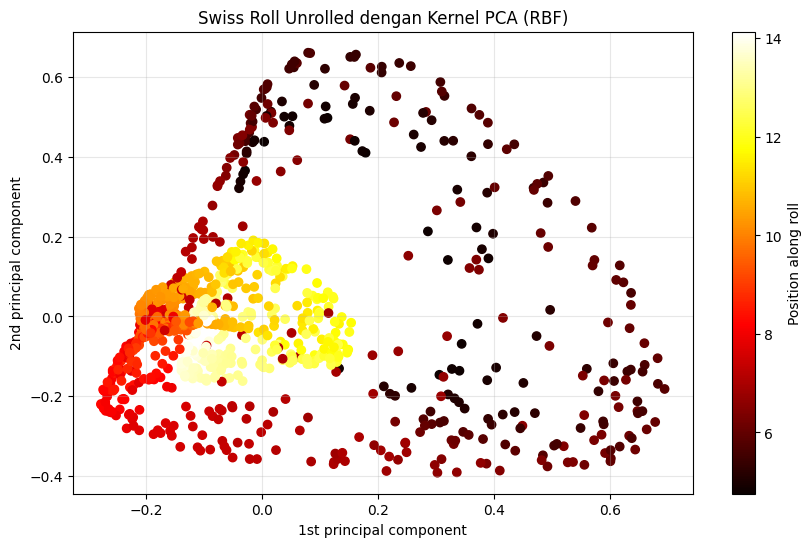

Swiss roll successfully unrolled!


In [15]:
# Visualisasi Kernel PCA results
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced_kpca[:, 0], X_reduced_kpca[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Swiss Roll Unrolled dengan Kernel PCA (RBF)")
plt.colorbar(label="Position along roll")
plt.grid(True, alpha=0.3)
plt.show()

print("Swiss roll successfully unrolled!")

### 5.3 Selecting Kernel dan Tuning Hyperparameters

**Method 1**: Use Grid Search dengan supervised learning task
- Create pipeline: kPCA → classifier
- Use GridSearchCV untuk find best kernel & hyperparameters
- Based on final classification accuracy

**Method 2**: Minimize reconstruction error (unsupervised)
- Use **reconstruction pre-image**
- Set `fit_inverse_transform=True`
- Measure MSE between original dan reconstructed

In [16]:
# Kernel PCA dengan reconstruction
rbf_pca_inv = KernelPCA(n_components=2, kernel="rbf", gamma=0.04,
                        fit_inverse_transform=True, random_state=42)
X_reduced_inv = rbf_pca_inv.fit_transform(X_swiss)
X_preimage = rbf_pca_inv.inverse_transform(X_reduced_inv)

# Reconstruction error
recon_error = mean_squared_error(X_swiss, X_preimage)

print("=== Kernel PCA Reconstruction ===")
print(f"Reconstruction pre-image error: {recon_error:.2f}")
print("Can use untuk select best kernel & hyperparameters!")

=== Kernel PCA Reconstruction ===
Reconstruction pre-image error: 31.83
Can use untuk select best kernel & hyperparameters!


## 6. LLE (Locally Linear Embedding)

**LLE** adalah powerful **nonlinear dimensionality reduction (NLDR)** technique.

### 6.1 Characteristics

- **Manifold Learning** technique
- **Does NOT rely on projections**
- Particularly good at **unrolling twisted manifolds**
- Works best dengan little noise

### 6.2 How LLE Works

**Step 1**: Measure how each instance linearly relates to closest neighbors

Minimize:
\\[ \sum_{i=1}^{m} \left( x^{(i)} - \sum_{j=1}^{m} w_{i,j} x^{(j)} \right)^2 \\]

**Step 2**: Find low-dimensional representation where local relationships preserved

Minimize:
\\[ \sum_{i=1}^{m} \left( z^{(i)} - \sum_{j=1}^{m} w_{i,j} z^{(j)} \right)^2 \\]

### 6.3 Computational Complexity

- O(m log(m) n log(k)): Finding k nearest neighbors
- O(mnk³): Optimizing weights
- O(dm²): Constructing low-dimensional representations

**Issue**: m² term makes it scale poorly untuk very large datasets

In [17]:
# LLE pada Swiss roll
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_swiss)

print("=== Locally Linear Embedding ===")
print(f"n_components: 2")
print(f"n_neighbors: 10")
print(f"Reduced shape: {X_reduced_lle.shape}")

=== Locally Linear Embedding ===
n_components: 2
n_neighbors: 10
Reduced shape: (1000, 2)


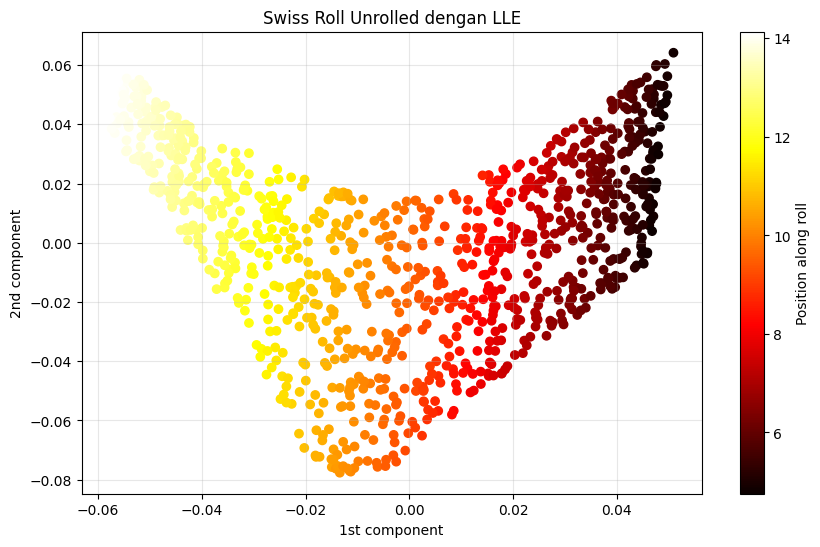


Observasi:
- Swiss roll completely unrolled
- Local distances well preserved
- Some stretching/squeezing pada larger scales


In [18]:
# Visualisasi LLE results
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.title("Swiss Roll Unrolled dengan LLE")
plt.colorbar(label="Position along roll")
plt.grid(True, alpha=0.3)
plt.show()

print("\nObservasi:")
print("- Swiss roll completely unrolled")
print("- Local distances well preserved")
print("- Some stretching/squeezing pada larger scales")

## 7. Other Dimensionality Reduction Techniques

### 7.1 Random Projections

**Method**: Projects data to lower-dimensional space menggunakan random linear projection.

**Key insight**: Random projection actually likely to preserve distances well (Johnson-Lindenstrauss lemma).

**Quality depends on**: Number of instances dan target dimensionality (NOT initial dimensionality!).

### 7.2 MDS (Multidimensional Scaling)

**Goal**: Reduce dimensionality while trying to preserve **distances** between instances.

### 7.3 Isomap

**Method**:
1. Create graph connecting each instance to nearest neighbors
2. Reduce dimensionality while preserving **geodesic distances**

**Geodesic distance**: Number of nodes pada shortest path between nodes.

### 7.4 t-SNE (t-Distributed Stochastic Neighbor Embedding)

**Goal**: Keep similar instances close dan dissimilar instances apart.

**Primary use**: **Visualization**
- Visualize clusters dalam high-dimensional space
- Example: MNIST images dalam 2D

### 7.5 LDA (Linear Discriminant Analysis)

**Type**: Classification algorithm

**Method**: 
- Learns most discriminative axes between classes
- Defines hyperplane untuk projection

**Benefit**: Projection keeps classes as far apart as possible.

**Usage**: Good technique sebelum running another classifier (e.g., SVM).

C:\Users\HP Pavilion 15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


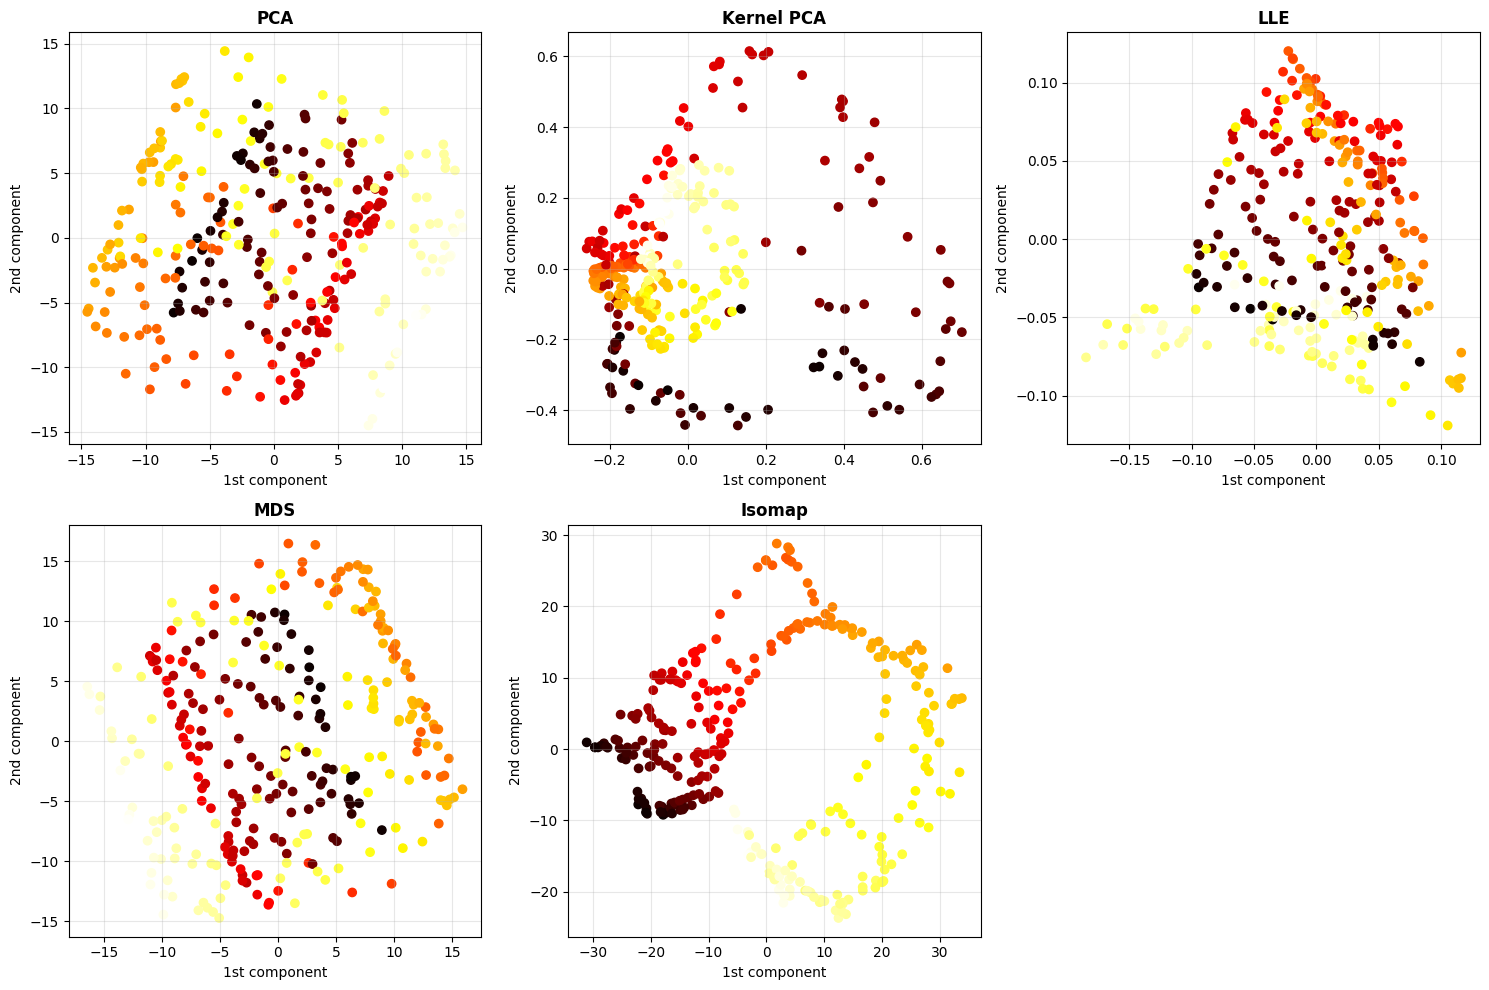


Comparison of different dimensionality reduction techniques
Each has strengths untuk different types of data!


In [19]:
# Comparison of techniques (demonstration)
from sklearn.manifold import MDS, Isomap, TSNE

# Sample smaller dataset untuk speed
X_sample = X_swiss[:300]
t_sample = t[:300]

# Apply different techniques
techniques = {
    'PCA': PCA(n_components=2),
    'Kernel PCA': KernelPCA(n_components=2, kernel="rbf", gamma=0.04),
    'LLE': LocallyLinearEmbedding(n_components=2, n_neighbors=10),
    'MDS': MDS(n_components=2, random_state=42),
    'Isomap': Isomap(n_components=2),
}

plt.figure(figsize=(15, 10))

for idx, (name, technique) in enumerate(techniques.items(), 1):
    plt.subplot(2, 3, idx)
    X_reduced = technique.fit_transform(X_sample)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t_sample, cmap=plt.cm.hot)
    plt.title(name, fontweight='bold')
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison of different dimensionality reduction techniques")
print("Each has strengths untuk different types of data!")

## 8. Summary & Best Practices

### When to Use Dimensionality Reduction:

✓ **Training too slow**: Speed up dengan reducing features

✓ **Data visualization**: Reduce to 2D/3D untuk plotting

✓ **Curse of dimensionality**: Dataset sparse dalam high dimensions

✓ **Storage**: Compress data untuk save space

✓ **Noise filtering**: May improve performance

### Technique Selection:

**PCA**:
- First choice untuk most problems
- Fast, simple, effective
- Linear projections only
- Use `n_components=0.95` untuk preserve 95% variance

**Incremental PCA**:
- Large datasets that don't fit in memory
- Online learning
- Use mini-batches

**Randomized PCA**:
- Much faster untuk large datasets
- Good approximation
- Automatically used by default when appropriate

**Kernel PCA**:
- Nonlinear manifolds
- Use RBF kernel as starting point
- Tune dengan grid search
- Can use reconstruction error untuk hyperparameter selection

**LLE**:
- Twisted manifolds
- Preserves local relationships
- Doesn't scale well untuk very large datasets

**t-SNE**:
- **Primarily for visualization**
- Excellent untuk visualizing clusters
- Slow untuk large datasets

**LDA**:
- Supervised dimensionality reduction
- Keeps classes far apart
- Use sebelum classification

### Important Notes:

⚠️ **Try original data first**: Before applying dimensionality reduction

⚠️ **Information loss**: Always some information lost

⚠️ **Pipeline complexity**: Makes maintenance harder

⚠️ **Not always helpful**: May hurt performance

✓ **Manifold assumption**: Often holds untuk real-world data

✓ **Visualization**: Essential untuk understanding data

✓ **Combine techniques**: Can chain different methods

✓ **Cross-validation**: Use untuk select best technique & hyperparameters

## Kesimpulan

Chapter 8 memberikan comprehensive understanding tentang Dimensionality Reduction:

✓ **Curse of Dimensionality**: High-dimensional spaces behave counterintuitively

✓ **Main Approaches**: Projection vs Manifold Learning

✓ **PCA**: Most popular technique, preserves maximum variance

✓ **Incremental PCA**: For large datasets, mini-batch processing

✓ **Randomized PCA**: Fast approximation untuk large datasets

✓ **Kernel PCA**: Nonlinear projections menggunakan kernel trick

✓ **LLE**: Preserves local linear relationships, good untuk twisted manifolds

✓ **Other Techniques**: t-SNE, MDS, Isomap, LDA, Random Projections

✓ **Trade-offs**: Speed vs accuracy, linear vs nonlinear, interpretability

Dimensionality reduction adalah **essential technique** untuk handling high-dimensional data. Dapat significantly speed up training, enable data visualization, dan sometimes improve performance. **PCA** adalah excellent starting point, dengan **Kernel PCA** dan **LLE** untuk more complex manifolds, dan **t-SNE** primarily untuk visualization.

---
